# Introducción 

La idea de la práctica es visitar aquellos temas que en cierta manera nos permitan ver más contenido del curso.

La práctica esta dividida en 4 o 5 subapartados, que ya tenéis en este mismo Notebook. Estos subapartados estan aquí para que rellenéis el código que hace falta para la realización de la práctica. Obviamente podéis usar tantas celdas como os hagan falta, es más es de agradecer si el código final esta algo "limpio". Usar funciones, algo de comentario, etc, etc...

Usaremos 2 datasets, uno para el primer ejercicio, y otro para el resto de ejercicios.

Ejercicios:


1.   Machine Learning vs Deep Learning (Acordaros que hay que implementar el pipeline visto en clase entero)

    1.1. Implementación de un modelo de Sentiment Analysis con algún algoritmo de Machine Learning Clásico.
    
    1.2. Implementación de un modelo de Sentiment Analysis con alguna arquitectura de Deep Learning.
    
    1.3. Breve Comparación de resultados. Confusion Matrix.
    
2. Hacer Analysis de los tweets del segundo dataset. Que temas aparecen? Como se representan estos temas? De que hablan unos y otros?

3. Escoged a uno de los dos presidentes, y escribid tweets como ellos, usando un Modelo Generativo.

En cada ejercicio, espero explicaciones y razonamientos del porque una arquitectura y no otra, por ejemplo en Deep Learning, porque usar Convolutionals en lugar de recurrentes, o en Machine Learning, Bayes en lugar de SVM. Hay que explicar el pipeline, sobretodo el preproceso de datos, con lo que habrá que hacer un pequeño estudio de que datos tenemos, y si hay cosas que se pueden ignorar, si hacéis stemming, o no, etc, etc...

Acordaros de que objetivo final no es que obtengáis una accuracy brutal, es que comprendais que pasa cuando usais un algoritmo u otro, y que problemas o beneficios nos dan.

![](https://i.pinimg.com/736x/19/63/8c/19638c0b33e2f7822d6806ce31d89d84--funny-cartoons-funny-jokes.jpg =400x)

Mucha suerte y ánimo!



In [0]:
!pip install spacy
!python -m spacy download en_core_web_md
!pip install stop_words
!pip install gensim
!pip install pyLDAvis

In [0]:
from google.colab import files
import numpy as np
import pandas as pd
import json
import io
import spacy
from stop_words import get_stop_words
from string import punctuation
from gensim.corpora import Dictionary
from gensim import corpora, models, similarities
import pyLDAvis.gensim
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [0]:
nlp = spacy.load('en_core_web_md')

In [3]:
uploaded = files.upload()

Saving dataset2.json to dataset2.json


Comenzamos cargando los dato del json en un dataframe de pandas para analizarlos

In [31]:
tweets = json.loads(uploaded['dataset2.json'])
df =  pd.DataFrame([[x['tweet'], x['label']] for x in tweets.values() ], columns=['tweet','label'])
df.head()

,tweet,label
0,"“Low plastic stool, cheap but delicious noodle...",OBAMA
1,"“Low plastic stool, cheap but delicious noodle...",OBAMA
2,"This National Gun Violence Awareness Day, show...",OBAMA
3,We can never truly repay the debt we owe our f...,OBAMA
4,This Center is for the leaders of tomorrow who...,OBAMA


In [40]:
df.label.unique()

array(['OBAMA', 'TRUMP'], dtype=object)

Tenemos textos de tweets de en la primera columna y quein los ha escrito en la segunda. En este caso solo tenemos tweets de obama y de trump, los vamos a separar para analizarlos por separado

Preparamos el dataset

In [0]:
stop_words = get_stop_words('en') + list(punctuation) + [' ']

def documents(label):
  documents = []
  for row in df[df['label'] == label].iterrows():
    _, info = row
    text, _ = info
    text = [t.text for t in nlp(text.rstrip(), disable=['parser', 'tagger', 'ner']) if t.text not in stop_words]
    documents.append(text)
  return documents 
      
documentsOBAMA = documents('OBAMA')
documentsTRUMP = documents('TRUMP')

Construimos los diccionarios con gensim

In [67]:
dictOBAMA = Dictionary(documentsOBAMA)
dictTRUMP = Dictionary(documentsTRUMP)
print('dictOBAMA',len(dictOBAMA))
print('dictTRUMP',len(dictTRUMP))

dictOBAMA 7110
dictTRUMP 9657


In [0]:
corpusOBAMA = [gensim_dict.doc2bow(doc) for doc in documentsOBAMA]
corpusTRUMP = [gensim_dict.doc2bow(doc) for doc in documentsTRUMP]

## Estudio de los tweets

A continuación vamos a realizar un análisis de los tweets. es un caso de topic modeling, donde queremos optener los diferentes temas de los que se habla. Para ello utilizaremos la impementación de gensim del algoritmo LDA y lo visualizaremos

Analizaremos por separado los tweets de trump y de obama. 

### Estudio de los tweets de  Obama

En primer lugar vamos a ver el numero de topics mas coherente

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics, iterations=5, passes=20, alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

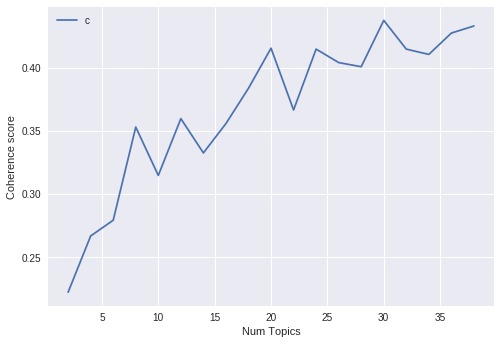

In [85]:
limit=40; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=dictOBAMA, corpus=corpusOBAMA, texts=documentsOBAMA, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

El numero optimo de topics es 30, vamos a crear nuestro modelo con este numero

In [0]:
lda_model = models.LdaModel(corpusOBAMA, id2word=dictOBAMA, num_topics=30, iterations=5, passes=20, alpha='auto')

In [89]:
vis = pyLDAvis.gensim.prepare(lda_model, corpusOBAMA, dictOBAMA)
pyLDAvis.display(vis)

Analizando los resultados obtenidos en la visualización podemos observar diferentes temáticas como las siguientes


*   El trabajo en america y america como lider mundial
*   Cambio climático
*   Leyes de control de armas
*   La reforma de la sanidad de obama



### Estudio de los tweets de  Obama

A continuación realizamos el mismo proceso para TRUMP

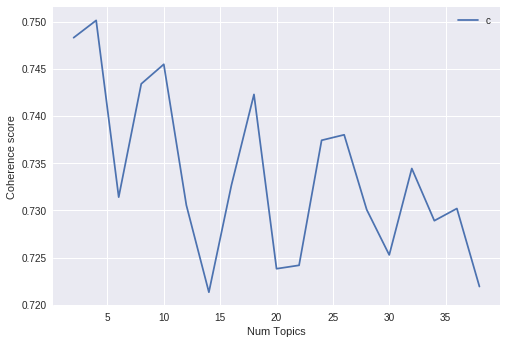

In [90]:
limit=40; start=2; step=2;
model_list, coherence_values = compute_coherence_values(dictionary=dictTRUMP, corpus=corpusTRUMP, texts=documentsTRUMP, start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

El caso de trump es muy diferente, parecee que el numero de temáticas de las que habla es muy diferente (de esperar quiza...)

In [0]:
lda_model = models.LdaModel(corpusTRUMP, id2word=dictTRUMP, num_topics=4, iterations=5, passes=20, alpha='auto')

In [92]:
vis = pyLDAvis.gensim.prepare(lda_model, corpusTRUMP, dictTRUMP)
pyLDAvis.display(vis)

Analizando los resultados obtenidos en la visualización podemos observar diferentes temáticas como las siguientes

*    Teorias de la conspiración (spygate) 
*    Caso de mo farah, atleta olimpico americano nacido en somalia
*    Temas como el de Rusia y Corea 
